# Vectorization
---

## Drive Mounting

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
current_folder = "/content/gdrive/My Drive/Workshop/TOM/"
os.chdir(current_folder)

## Clean Data Loading

In [17]:
import pandas as pd
df = pd.read_csv("repos.csv", encoding="latin1")
df.sample(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title,clean_body,code_body
15527,15527,NaN,NaN,MEMBER,#### System information: \r\n- Operating syste...,NaN,0,https://api.github.com/repos/dbeaver/dbeaver/i...,2021-12-08T14:02:03Z,NaN,https://api.github.com/repos/dbeaver/dbeaver/i...,https://github.com/dbeaver/dbeaver/issues/14843,1074444128,https://api.github.com/repos/dbeaver/dbeaver/i...,False,NaN,I_kwDOAql_jc5ACrdg,14843,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/dbeaver/dbeaver/i...,https://api.github.com/repos/dbeaver/dbeaver,open,https://api.github.com/repos/dbeaver/dbeaver/i...,Wrong path is opened when clicking browse in e...,2021-12-08T14:02:28Z,https://api.github.com/repos/dbeaver/dbeaver/i...,Wrong path is opened when clicking browse in e...,without code,System Operating system and version version De...,with code
9916,9916,NaN,NaN,NONE,In our project we have very complex security r...,NaN,0,https://api.github.com/repos/spring-projects/s...,2020-11-27T23:47:02Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-secu...,752507117,https://api.github.com/repos/spring-projects/s...,False,NaN,MDU6SXNzdWU3NTI1MDcxMTc=,9225,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,ACL add String AccessControlEntry#getKey(),2020-12-02T11:17:12Z,https://api.github.com/repos/spring-projects/s...,add String,with code,In our project we have very complex security W...,with code


In [18]:
length_before = df.shape[0]
df.dropna(subset=["clean_title"], inplace=True)
length_after = df.shape[0]
print("We droped {} elements of {}".format(length_before - length_after, length_before))

We droped 2715 elements of 34268


In [19]:
from collections import defaultdict
dicc = defaultdict(int)

for element in df["clean_title"]:
    dicc[str(type(element))] += 1

dicc

defaultdict(int, {"<class 'str'>": 31553})

In [20]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head(2)

,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title,clean_body,code_body
0,NaN,NaN,NONE,I put the problem in MD,NaN,1,https://api.github.com/repos/spring-projects/s...,2021-12-11T02:13:23Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1077359600,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5ANzPw,28991,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,JDK17 And SpringBoot-3.0.0-SNAPSHOT,2021-12-11T02:16:56Z,https://api.github.com/repos/spring-projects/s...,And,with code,I put the problem in,without code
1,NaN,NaN,NONE,"I cannot include the actual code here, but I w...",NaN,0,https://api.github.com/repos/spring-projects/s...,2021-12-10T22:32:04Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1077283209,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5ANgmJ,28990,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Dev Tools: Request Scoped Bean Not Working Whe...,2021-12-11T00:46:11Z,https://api.github.com/repos/spring-projects/s...,Dev Request Scoped Bean Not Working When Inclu...,with code,I cannot include the actual code but I will cr...,with code


In [21]:
titles_no_code = df[df["code_title"]=="without code"]
titles_no_code.shape

(17749, 38)

## The Corpus

In [8]:
# corpus = [text.lower() for text in df["clean_title"].values if text!=""]
# print("We are using {} titles of {}".format(len(corpus), df.shape[0]))
corpus = [text.lower() for text in titles_no_code["clean_title"].values if text!=""]
print("We are using {} titles of {}".format(len(corpus), titles_no_code.shape[0]))

We are using 17749 titles of 17749


## TF/IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf = TfidfVectorizer(analyzer="word", ngram_range=(1,1), min_df=0)

# Initialize an instance of tf-idf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Generate the tf-idf vectors for the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)


In [10]:
tfidf_matrix.shape

(17749, 7929)

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [12]:
similarity_matrix.shape

(17749, 17749)

In [13]:
import numpy as np

weights = similarity_matrix[np.triu_indices(similarity_matrix.shape[0], 1)]

In [14]:
her, hin = np.triu_indices_from(similarity_matrix, 1)

In [15]:
import pandas as pd

graff = pd.DataFrame(data=weights, columns=["weight"])
graff.head(2)

,weight
0,0.0
1,0.0


In [16]:
graff["from"] = her
graff["to"] = hin

In [17]:
graff.head(3)

,weight,from,to
0,0.0,0,1
1,0.0,0,2
2,0.0,0,3


In [4]:
# edges = list(zip(*np.triu_indices_from(similarity_matrix, 1)))
# edges = zip(her, hin)

In [18]:
# graff.to_csv("graff.csv")

## Communities

In [3]:
import pandas as pd

graff = pd.read_csv("graff.csv")
print(graff.shape)

(157504626, 4)


In [6]:
fives = graff[graff["weight"]>=float(0.5)]
sevens = graff[graff["weight"]>=float(0.7)]
nines = graff[graff["weight"]>=float(0.9)]

In [7]:
print(fives.shape)
print(sevens.shape)
print(nines.shape)

(31724, 4)
(9774, 4)
(5070, 4)


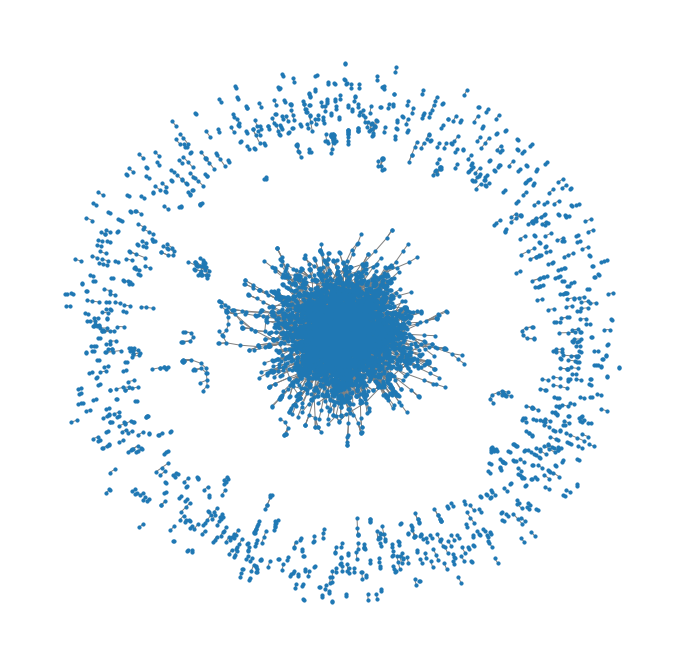

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,12))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

U = nx.from_pandas_edgelist(fives, source="from", target="to", edge_attr="weight")
nx.draw(U, pos=nx.spring_layout(U, seed=7), node_size=10, edge_color="gray", alpha=1)

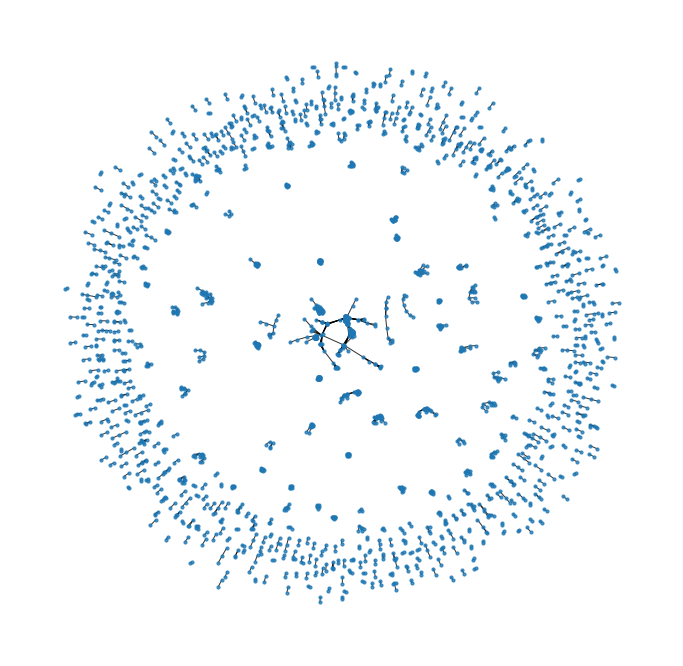

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

V = nx.from_pandas_edgelist(sevens, source="from", target="to", edge_attr="weight")
nx.draw(V, pos=nx.spring_layout(V, seed=7), node_size=10, edge_color="k", alpha=0.8)

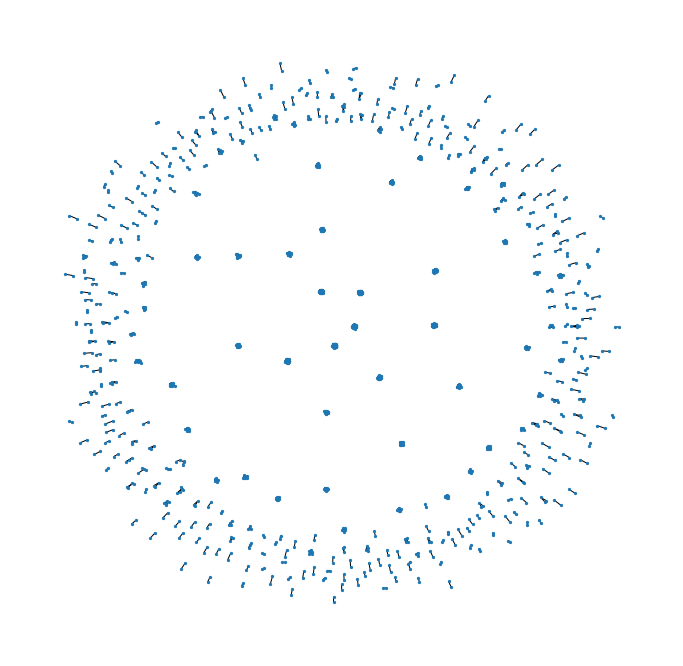

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

W = nx.from_pandas_edgelist(nines, source="from", target="to", edge_attr="weight")
nx.draw(W, pos=nx.spring_layout(W, seed=7), node_size=5, edge_color="k", alpha=1)

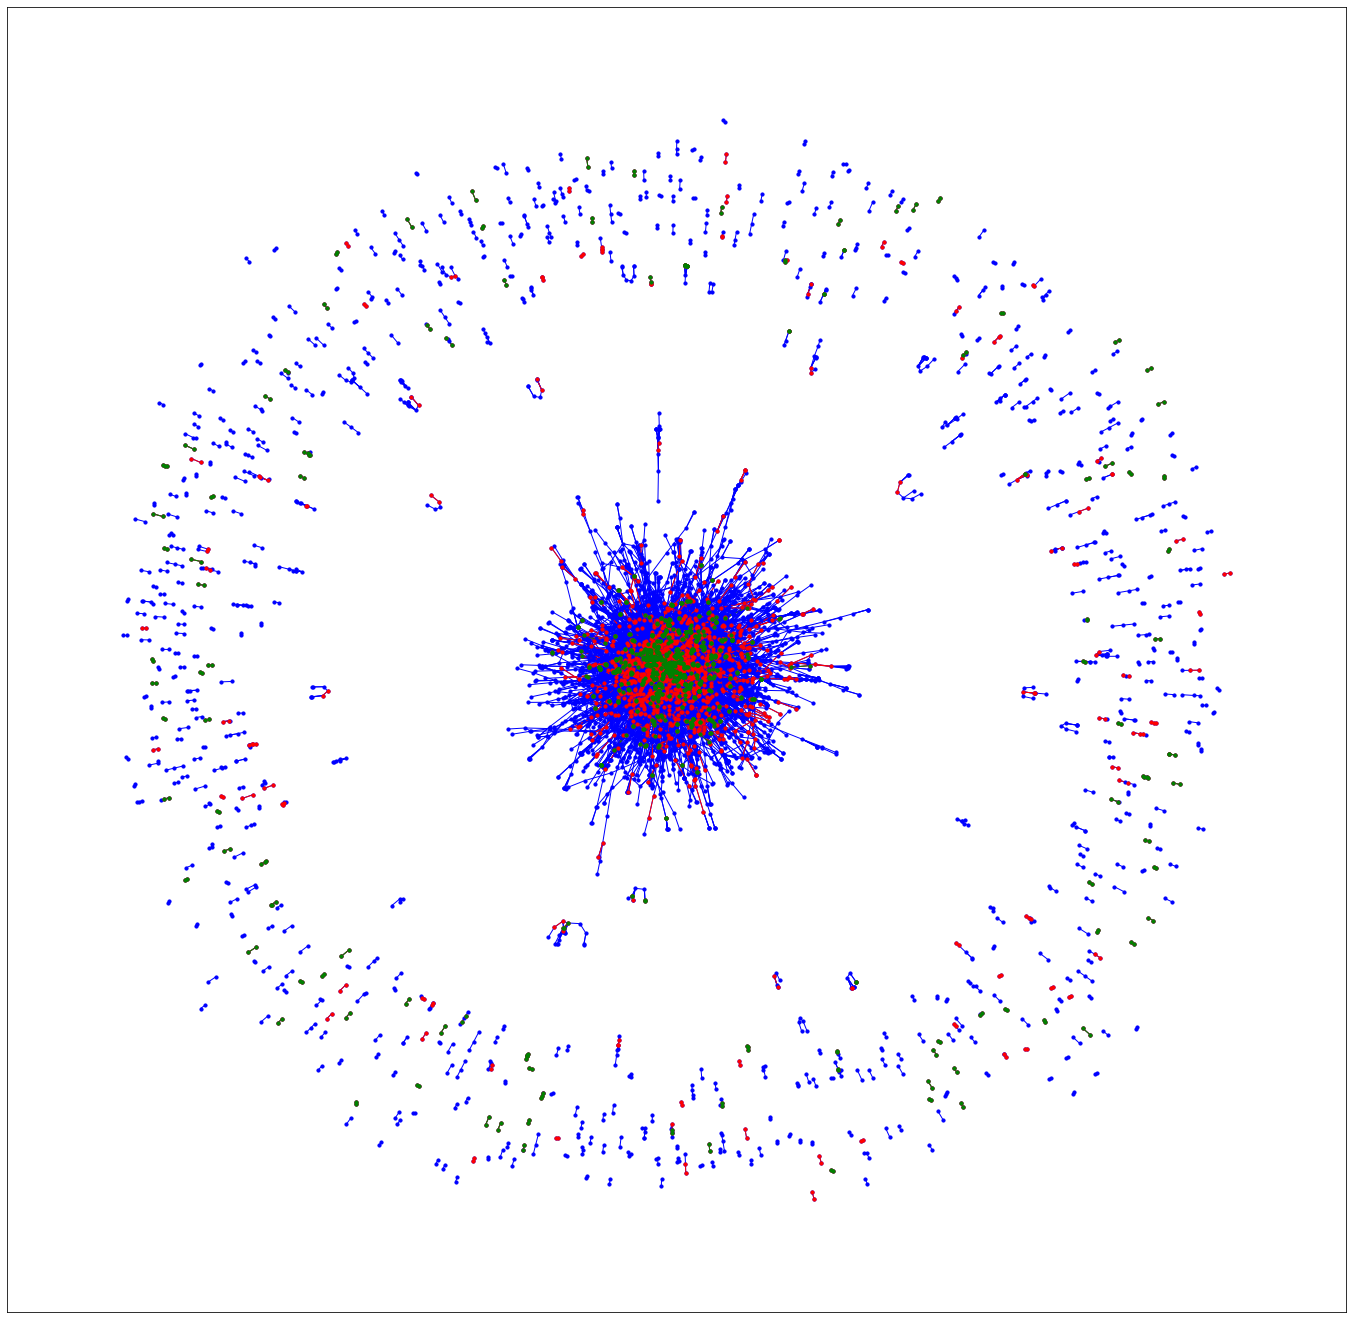

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

G = nx.Graph()
G.add_edges_from(U.edges)
G.add_edges_from(V.edges)
G.add_edges_from(W.edges)

pos = nx.spring_layout(G, seed=7)

nx.draw_networkx_nodes(U, pos=pos, nodelist=U.nodes, node_color="blue", node_size=10)
nx.draw_networkx_nodes(V, pos=pos, nodelist=V.nodes, node_color="red", node_size=10)
nx.draw_networkx_nodes(W, pos=pos, nodelist=W.nodes, node_color="green", node_size=10)

nx.draw_networkx_edges(U, pos=pos, nodelist=U.edges, alpha=1, edge_color="blue");
nx.draw_networkx_edges(V, pos=pos, nodelist=V.edges, alpha=1, edge_color="red");
nx.draw_networkx_edges(W, pos=pos, nodelist=G.edges, alpha=1, edge_color="green");
# nx.draw(W, pos=nx.circular_layout(W))

In [23]:
import community.community_louvain as clouvain
partition = clouvain.best_partition(G)
modularity = clouvain.modularity(partition, G)

In [24]:
print(type(partition), type(modularity))
pos = nx.spring_layout(G, dim=2)
community_id = [partition[node] for node in G.nodes()]

<class 'dict'> <class 'float'>


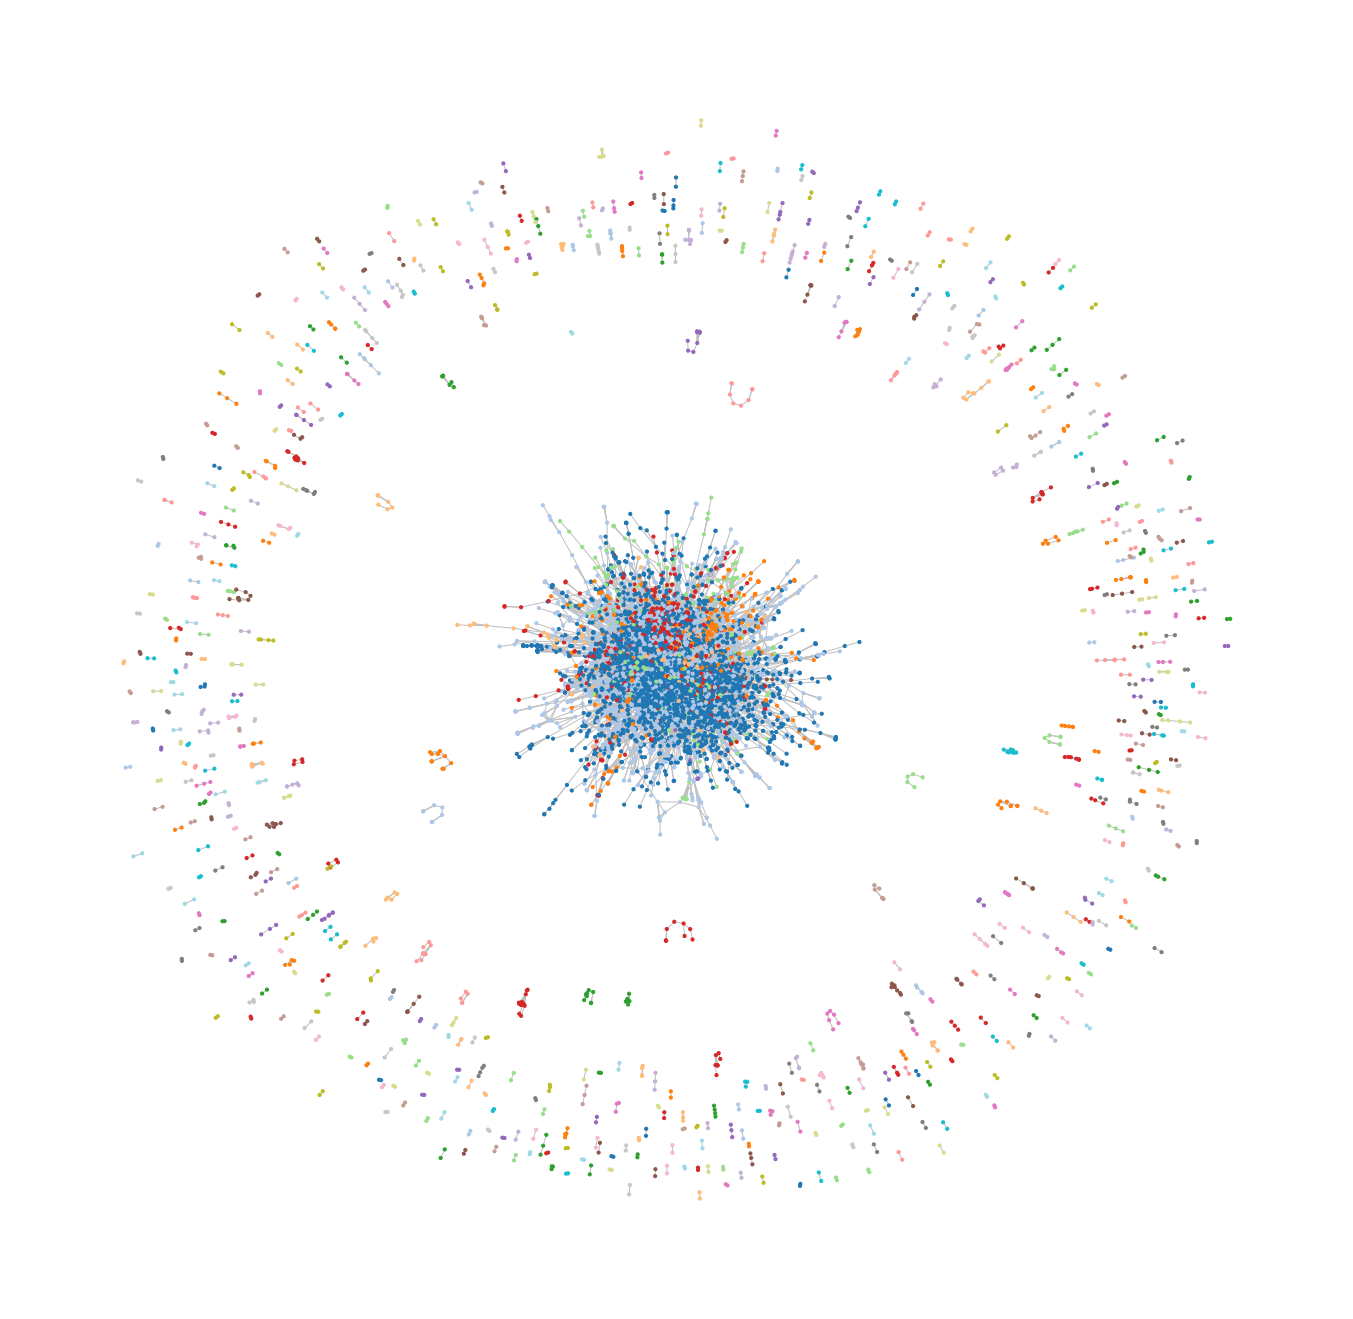

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

nx.draw(G, pos=pos, edge_color=['silver']*len(G.edges()), 
        cmap=plt.cm.tab20, node_color=community_id, node_size=10, alpha=1)

In [26]:
type(community_id), len(community_id)

(list, 8088)

In [27]:
from collections import defaultdict
elements_per_communities = defaultdict(int)
for element in community_id:
    elements_per_communities[str(element)] += 1

In [28]:
elements_per_communities

defaultdict(int,
            {'0': 2,
             '1': 2,
             '10': 141,
             '100': 6,
             '101': 2,
             '102': 2,
             '103': 18,
             '104': 5,
             '105': 2,
             '106': 11,
             '107': 267,
             '108': 4,
             '109': 4,
             '11': 130,
             '110': 138,
             '111': 2,
             '112': 8,
             '113': 2,
             '114': 7,
             '115': 2,
             '116': 5,
             '117': 11,
             '118': 3,
             '119': 2,
             '12': 119,
             '120': 5,
             '121': 2,
             '122': 2,
             '123': 3,
             '124': 4,
             '125': 2,
             '126': 2,
             '127': 5,
             '128': 4,
             '129': 2,
             '13': 338,
             '130': 2,
             '131': 2,
             '132': 2,
             '133': 3,
             '134': 8,
             '135': 2,
          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  """


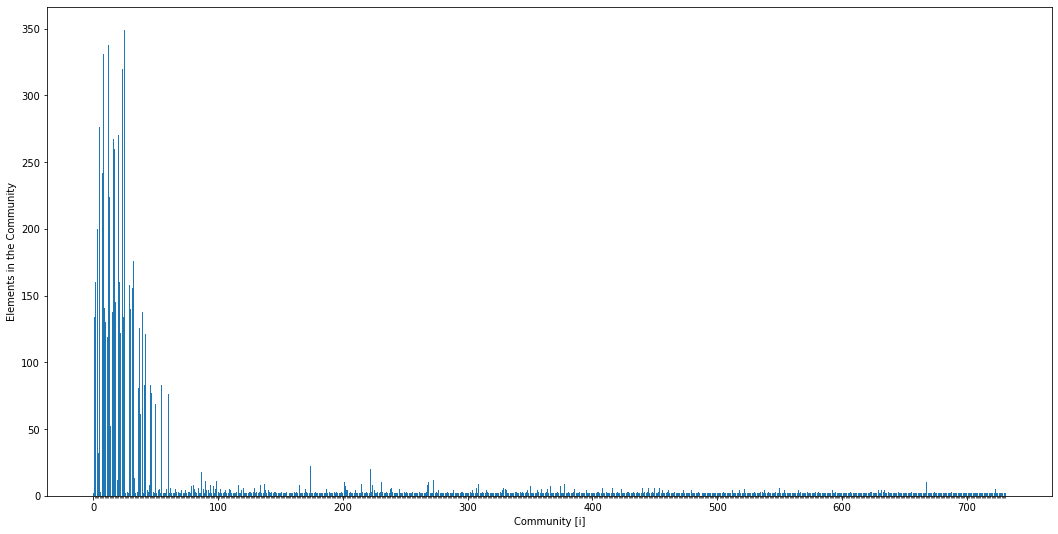

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(len(elements_per_communities)), list(elements_per_communities.values()), align='center')
ax.set_xticks(range(len(elements_per_communities)), list(elements_per_communities.keys()))
ax.set_ylabel("Elements in the Community")
ax.set_xlabel("Community [i]")
plt.show()

## Labeling

In [4]:
graffi = graff[graff["weight"]>=float(0.4)]

In [5]:
graffi.shape

(77596, 4)

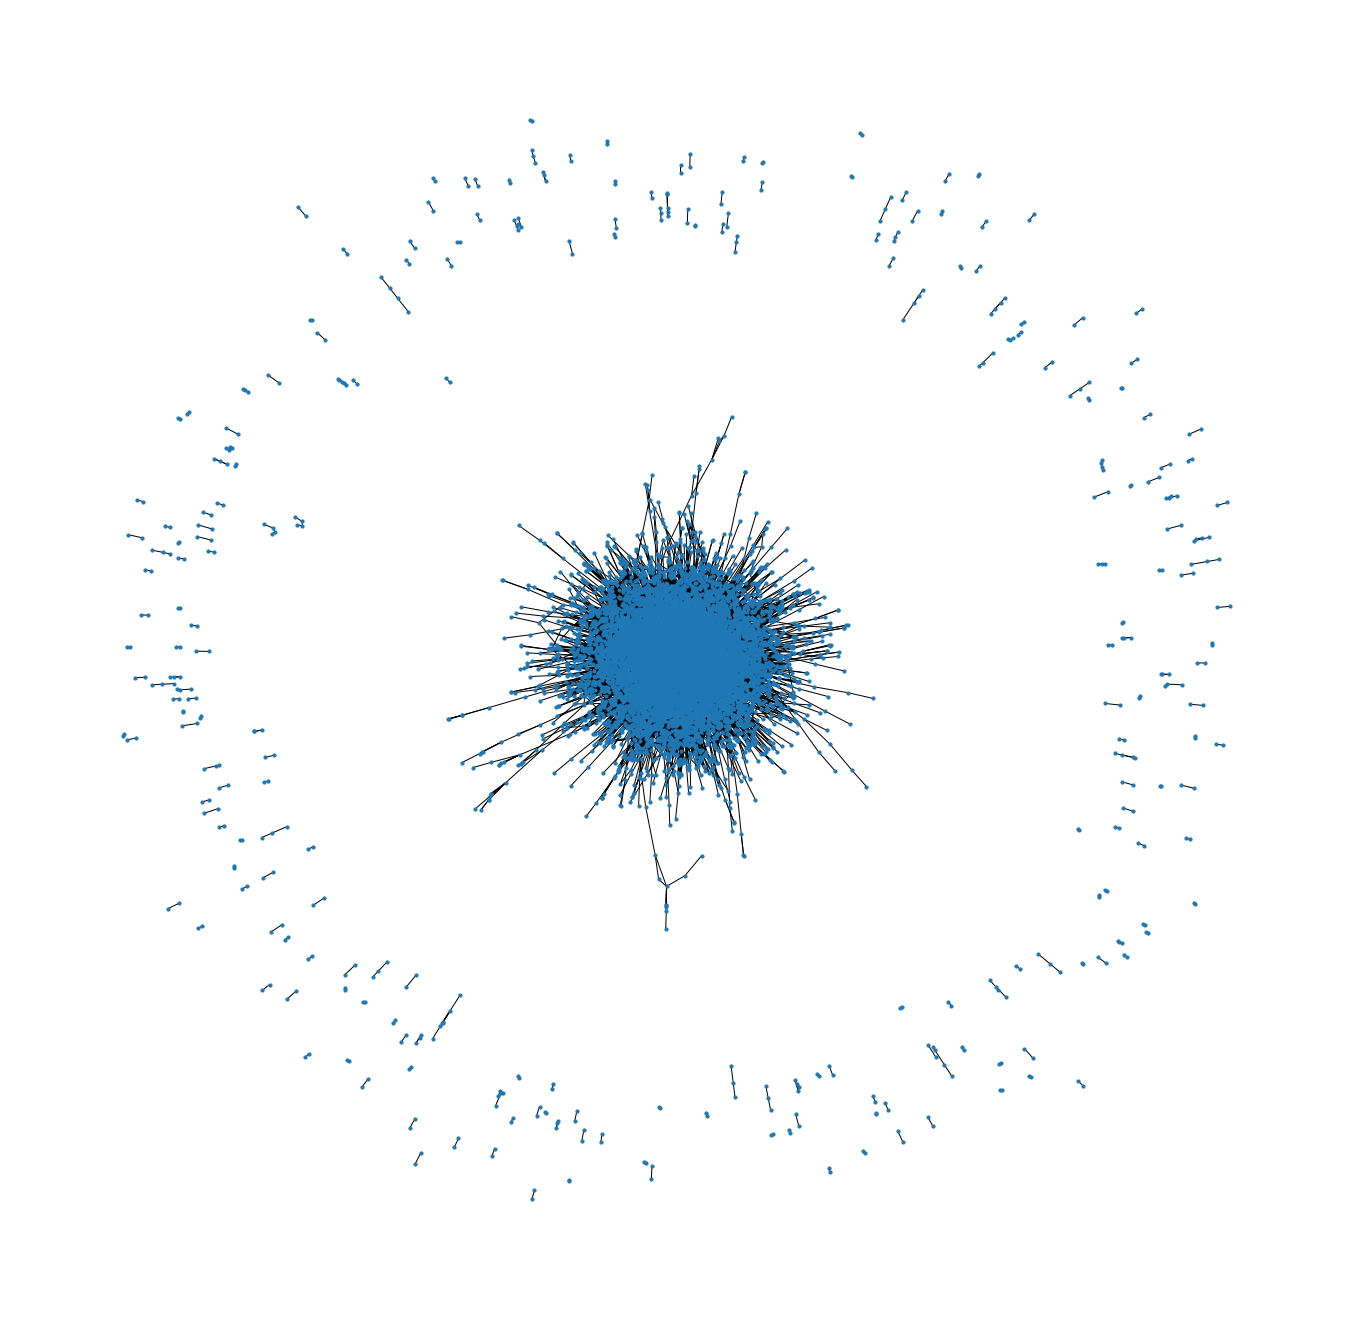

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

G = nx.from_pandas_edgelist(graffi, source="from", target="to", edge_attr="weight")
nx.draw(G, node_size=10, edge_color="k")


In [7]:
import community.community_louvain as clouvain
partition = clouvain.best_partition(G)
modularity = clouvain.modularity(partition, G)

In [8]:
print(type(partition), type(modularity))
pos = nx.spring_layout(G, dim=2)
community_id = [partition[node] for node in G.nodes()]
print(len(community_id))

<class 'dict'> <class 'float'>
13632


In [9]:
len(partition)

13632

In [10]:
from collections import defaultdict
elements_per_communities = defaultdict(int)
for element in community_id:
    elements_per_communities[str(element)] += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  """


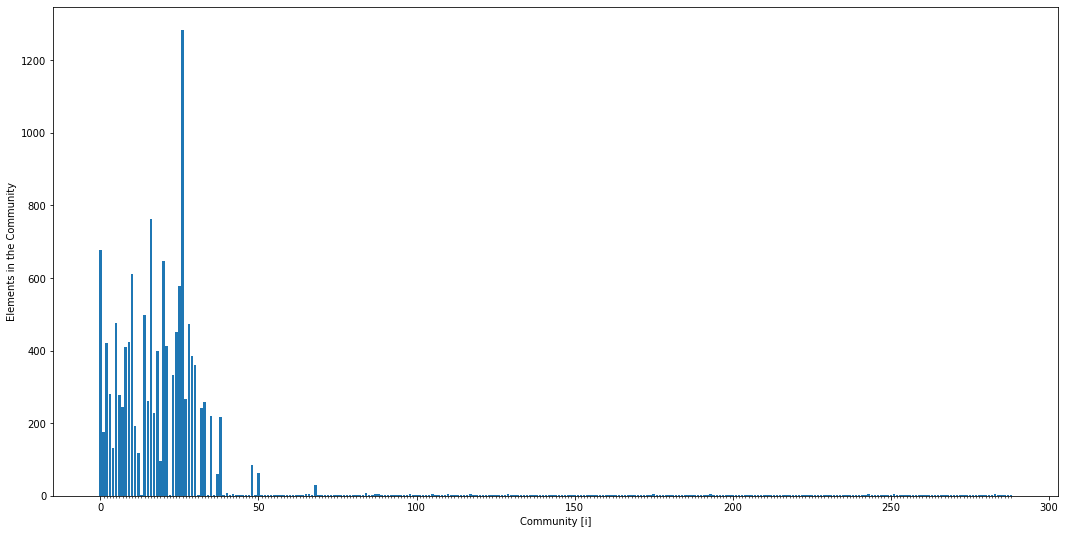

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(len(elements_per_communities)), list(elements_per_communities.values()), align='center')
ax.set_xticks(range(len(elements_per_communities)), list(elements_per_communities.keys()))
ax.set_ylabel("Elements in the Community")
ax.set_xlabel("Community [i]")
plt.show()

In [12]:
sum(elements_per_communities.values())

13632

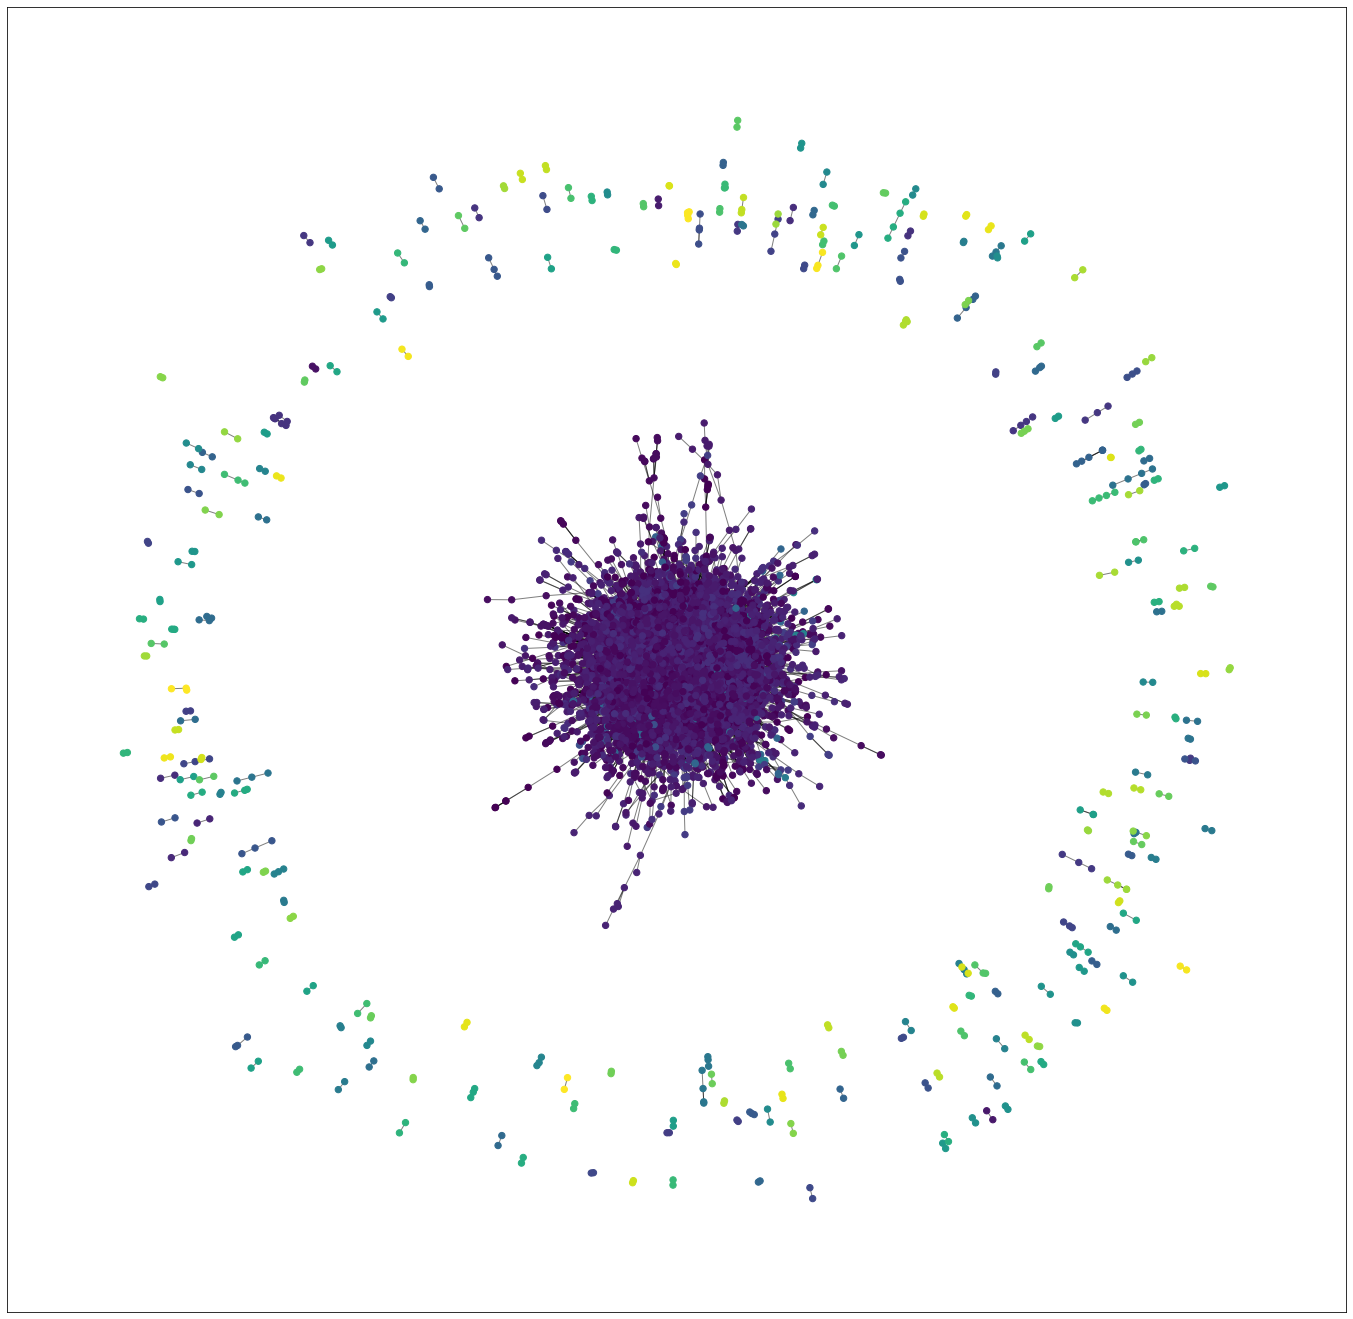

In [13]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

cmap = cm.get_cmap("viridis", max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# plt.show()

In [29]:
title, cluster = [], []
for i in partition.items():
    title.append(titles_no_code["clean_title"][i])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']

KeyError: ignored

In [15]:
frame_clust.shape

(13632, 2)

In [16]:
frame_clust

,Title,Cluster
0,0,0
1,143,0
2,15602,0
3,1,1
4,11239,1
...,...,...
13627,17626,19
13628,17628,19
13629,17639,30
13630,17686,30


In [31]:
titles_no_code["clean_title"]

2           triggers eager initialization of factory beans
3              Reinstate support for Spring Data Couchbase
16       Document that using with a remote application ...
17       kafka consumer metrics missing in micrometer a...
19                                      memory overflow in
                               ...                        
34255                for programmatic test plan generation
34257    Setters in need to set Properties to be picked...
34260                                               Update
34261                  assume we have correct at edit time
34265                                         when is near
Name: clean_title, Length: 17749, dtype: object

In [15]:
U.clear()
V.clear()
W.clear()

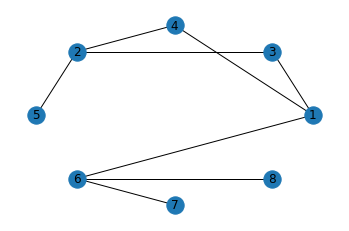

In [26]:
import networkx as nx
U = nx.Graph()
U.add_edges_from([(1,3), (1,4), (2,3), (2,4), (2,5), (1,6), (6,7), (6,8)])
nx.draw_networkx_labels(U, pos=nx.circular_layout(U))
nx.draw(U, pos=nx.circular_layout(U))

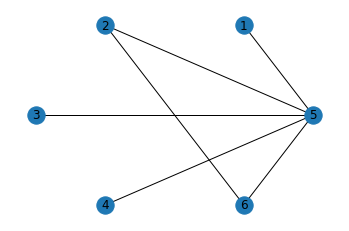

In [27]:
V = nx.Graph()
V.add_edges_from([(5,1), (5,2), (5,3), (5,4), (5,6), (6,2)])
nx.draw_networkx_labels(V, pos=nx.circular_layout(V))
nx.draw(V, pos=nx.circular_layout(V))

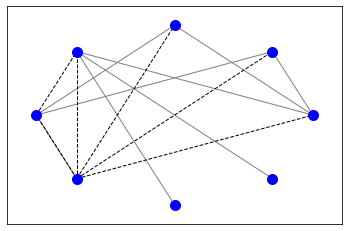

In [28]:
W = nx.Graph()
W.add_edges_from(U.edges)
W.add_edges_from(V.edges)

nx.draw_networkx_nodes(V, pos=nx.circular_layout(W), nodelist=V.nodes, node_color="red", node_size=10)
nx.draw_networkx_nodes(U, pos=nx.circular_layout(W), nodelist=U.nodes, node_color="blue", node_size=100)

nx.draw_networkx_edges(U, pos=nx.circular_layout(W), nodelist=U.edges, edge_color="gray");
nx.draw_networkx_edges(V, pos=nx.circular_layout(W), nodelist=V.edges, edge_color="k", style="dashed");
# nx.draw(W, pos=nx.circular_layout(W))

In [29]:
import community.community_louvain as clouvain
partition = clouvain.best_partition(W)
modularity = clouvain.modularity(partition, W)

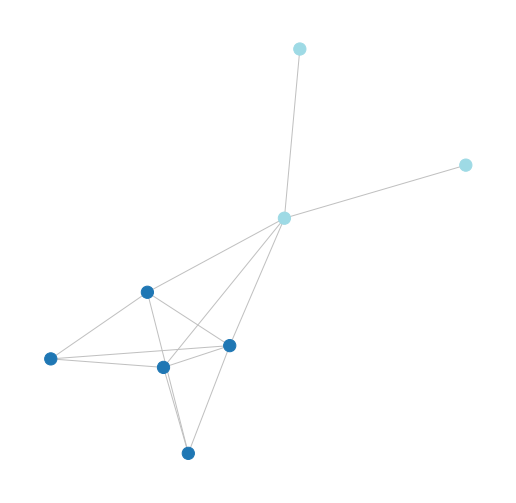

In [30]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(W, dim=2)
community_id = [partition[node] for node in W.nodes()]
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)

nx.draw(W, pos, edge_color = ['silver']*len(W.edges()), cmap=plt.cm.tab20,
        node_color=community_id, node_size=150)

In [31]:
import pandas as pd

title, cluster = [], []
for i in partition.items():
    title.append(i[0])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']
frame_clust

,Title,Cluster
0,1,0
1,3,0
2,4,0
3,6,1
4,2,0
5,5,0
6,7,1
7,8,1
